# Method 5 - Best Ideas DGTW Select

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_beg_pos = p.beg_port.iloc[1:].resample('M', level=0).apply(epd.take_first)
dgtw = crsp.get_dgtw_returns(list(set(best_ideas['fsym_id'].dropna())),
                    best_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
dgtw_pivot = pd.pivot_table(dgtw, index='datadate', columns='fsym_id', values='total_return')
dgtw_cont = monthly_beg_pos.mul(dgtw_pivot, axis=1, level=0).sum(axis=1)

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - dgtw_cont).dropna()
monthly_return.name = 'port_return'

## Plot Performance

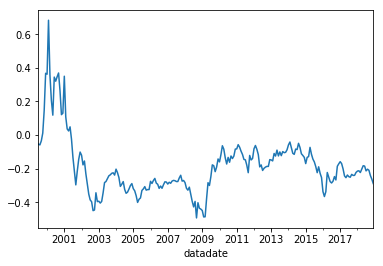

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.368043
2000-12-31   -0.173668
2001-12-31   -0.204830
2002-12-31   -0.328069
2003-12-31    0.261322
2004-12-31   -0.066543
2005-12-31   -0.049917
2006-12-31    0.066280
2007-12-31    0.012901
2008-12-31   -0.233509
2009-12-31    0.533643
2010-12-31    0.068628
2011-12-31   -0.061256
2012-12-31   -0.007590
2013-12-31    0.068550
2014-12-31   -0.049402
2015-12-31   -0.138358
2016-12-31    0.109115
2017-12-31   -0.062150
2018-12-31   -0.084950
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     75.23
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.25e-40
Time:                        04:47:12   Log-Likelihood:                 421.11
No. Observations:                 234   AIC:                            -832.2
Df Residuals:                     229   BIC:                            -814.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.003      0.607      0.545      -0.004       0.007
mktrf          0.2982      0.075      3.953      0.000       0.150       0.447
me             0.3914      0.088      4.461      0.000       0.219       0.564
ia            -0.3815      0.133     -2.861      0.005      -0.644      -0.119
roe           -0.9019      0.114     -7.901      0.000      -1.127      -0.677
==============================================================================
Omnibus:                      151.609   Durbin-Watson:                   2.200
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2749.981
Skew:                           2.164   Prob(JB):                         0.00
Kurtosis:                      19.227   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     45.78
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.12e-28
Time:                        04:47:12   Log-Likelihood:                 421.11
No. Observations:                 234   AIC:                            -832.2
Df Residuals:                     229   BIC:                            -814.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.002      0.688      0.492      -0.003       0.006
mktrf          0.2982      0.138      2.161      0.031       0.028       0.569
me             0.3914      0.172      2.277      0.023       0.055       0.728
ia            -0.3815      0.190     -2.006      0.045      -0.754      -0.009
roe           -0.9019      0.125     -7.188      0.000      -1.148      -0.656
==============================================================================
Omnibus:                      151.609   Durbin-Watson:                   2.200
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2749.981
Skew:                           2.164   Prob(JB):                         0.00
Kurtosis:                      19.227   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     59.83
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.58e-34
Time:                        04:47:12   Log-Likelihood:                 421.11
No. Observations:                 234   AIC:                            -832.2
Df Residuals:                     229   BIC:                            -814.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.003      0.661      0.509      -0.003       0.007
mktrf          0.2982      0.130      2.292      0.022       0.043       0.553
me             0.3914      0.182      2.151      0.031       0.035       0.748
ia            -0.3815      0.193     -1.976      0.048      -0.760      -0.003
roe           -0.9019      0.125     -7.204      0.000      -1.147      -0.657
==============================================================================
Omnibus:                      151.609   Durbin-Watson:                   2.200
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2749.981
Skew:                           2.164   Prob(JB):                         0.00
Kurtosis:                      19.227   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     61.42
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.36e-40
Time:                        04:47:12   Log-Likelihood:                 422.76
No. Observations:                 234   AIC:                            -833.5
Df Residuals:                     228   BIC:                            -812.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.003      0.535      0.593      -0.004       0.007
mktrf          0.3833      0.075      5.095      0.000       0.235       0.531
smb            0.3466      0.099      3.492      0.001       0.151       0.542
hml           -0.0955      0.117     -0.816      0.415      -0.326       0.135
rmw           -0.9388      0.132     -7.095      0.000      -1.199      -0.678
cma            0.0126      0.168      0.075      0.940      -0.319       0.344
==============================================================================
Omnibus:                      149.980   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1903.094
Skew:                           2.277   Prob(JB):                         0.00
Kurtosis:                      16.208   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     57.85
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.09e-38
Time:                        04:47:12   Log-Likelihood:                 422.76
No. Observations:                 234   AIC:                            -833.5
Df Residuals:                     228   BIC:                            -812.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.636      0.525      -0.003       0.006
mktrf          0.3833      0.089      4.328      0.000       0.210       0.557
smb            0.3466      0.121      2.856      0.004       0.109       0.584
hml           -0.0955      0.192     -0.496      0.620      -0.473       0.282
rmw           -0.9388      0.127     -7.405      0.000      -1.187      -0.690
cma            0.0126      0.185      0.068      0.946      -0.351       0.376
==============================================================================
Omnibus:                      149.980   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1903.094
Skew:                           2.277   Prob(JB):                         0.00
Kurtosis:                      16.208   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     105.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.96e-57
Time:                        04:47:12   Log-Likelihood:                 422.76
No. Observations:                 234   AIC:                            -833.5
Df Residuals:                     228   BIC:                            -812.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.610      0.542      -0.003       0.006
mktrf          0.3833      0.073      5.256      0.000       0.240       0.526
smb            0.3466      0.131      2.644      0.008       0.090       0.604
hml           -0.0955      0.168     -0.568      0.570      -0.425       0.234
rmw           -0.9388      0.118     -7.972      0.000      -1.170      -0.708
cma            0.0126      0.159      0.079      0.937      -0.300       0.325
==============================================================================
Omnibus:                      149.980   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1903.094
Skew:                           2.277   Prob(JB):                         0.00
Kurtosis:                      16.208   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     62.89
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.45e-36
Time:                        04:47:12   Log-Likelihood:                 409.67
No. Observations:                 234   AIC:                            -809.3
Df Residuals:                     229   BIC:                            -792.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.003     -0.768      0.444      -0.008       0.003
mktrf          0.5105      0.073      6.999      0.000       0.367       0.654
smb            0.7634      0.091      8.385      0.000       0.584       0.943
hml           -0.3257      0.090     -3.602      0.000      -0.504      -0.148
umd           -0.2289      0.059     -3.857      0.000      -0.346      -0.112
==============================================================================
Omnibus:                      130.514   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1524.757
Skew:                           1.904   Prob(JB):                         0.00
Kurtosis:                      14.912   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     33.69
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.21e-22
Time:                        04:47:12   Log-Likelihood:                 409.67
No. Observations:                 234   AIC:                            -809.3
Df Residuals:                     229   BIC:                            -792.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.002     -0.927      0.354      -0.007       0.002
mktrf          0.5105      0.114      4.484      0.000       0.287       0.734
smb            0.7634      0.155      4.931      0.000       0.460       1.067
hml           -0.3257      0.137     -2.386      0.017      -0.593      -0.058
umd           -0.2289      0.092     -2.496      0.013      -0.409      -0.049
==============================================================================
Omnibus:                      130.514   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1524.757
Skew:                           1.904   Prob(JB):                         0.00
Kurtosis:                      14.912   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     36.57
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.25e-23
Time:                        04:47:13   Log-Likelihood:                 409.67
No. Observations:                 234   AIC:                            -809.3
Df Residuals:                     229   BIC:                            -792.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.002     -0.924      0.356      -0.007       0.002
mktrf          0.5105      0.102      4.983      0.000       0.310       0.711
smb            0.7634      0.157      4.870      0.000       0.456       1.071
hml           -0.3257      0.132     -2.476      0.013      -0.584      -0.068
umd           -0.2289      0.087     -2.619      0.009      -0.400      -0.058
==============================================================================
Omnibus:                      130.514   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1524.757
Skew:                           1.904   Prob(JB):                         0.00
Kurtosis:                      14.912   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     41.21
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.17e-21
Time:                        04:47:13   Log-Likelihood:                 194.70
No. Observations:                 120   AIC:                            -379.4
Df Residuals:                     115   BIC:                            -365.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.005      0.857      0.393      -0.005       0.013
mktrf          0.1652      0.126      1.313      0.192      -0.084       0.414
me             0.4273      0.124      3.440      0.001       0.181       0.673
ia            -0.6244      0.195     -3.210      0.002      -1.010      -0.239
roe           -0.9191      0.172     -5.338      0.000      -1.260      -0.578
==============================================================================
Omnibus:                       73.065   Durbin-Watson:                   2.177
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              661.528
Skew:                           1.822   Prob(JB):                    2.24e-144
Kurtosis:                      13.910   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     52.89
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.30e-25
Time:                        04:47:13   Log-Likelihood:                 194.70
No. Observations:                 120   AIC:                            -379.4
Df Residuals:                     115   BIC:                            -365.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.004      1.075      0.282      -0.003       0.011
mktrf          0.1652      0.209      0.789      0.430      -0.245       0.575
me             0.4273      0.203      2.109      0.035       0.030       0.824
ia            -0.6244      0.252     -2.475      0.013      -1.119      -0.130
roe           -0.9191      0.184     -5.007      0.000      -1.279      -0.559
==============================================================================
Omnibus:                       73.065   Durbin-Watson:                   2.177
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              661.528
Skew:                           1.822   Prob(JB):                    2.24e-144
Kurtosis:                      13.910   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     72.96
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.18e-30
Time:                        04:47:13   Log-Likelihood:                 194.70
No. Observations:                 120   AIC:                            -379.4
Df Residuals:                     115   BIC:                            -365.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.004      1.072      0.284      -0.003       0.011
mktrf          0.1652      0.198      0.834      0.404      -0.223       0.553
me             0.4273      0.215      1.990      0.047       0.006       0.848
ia            -0.6244      0.236     -2.642      0.008      -1.088      -0.161
roe           -0.9191      0.197     -4.668      0.000      -1.305      -0.533
==============================================================================
Omnibus:                       73.065   Durbin-Watson:                   2.177
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              661.528
Skew:                           1.822   Prob(JB):                    2.24e-144
Kurtosis:                      13.910   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     35.98
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.86e-22
Time:                        04:47:13   Log-Likelihood:                 198.17
No. Observations:                 120   AIC:                            -384.3
Df Residuals:                     114   BIC:                            -367.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.005      0.962      0.338      -0.005       0.014
mktrf          0.3698      0.129      2.858      0.005       0.113       0.626
smb            0.4262      0.147      2.908      0.004       0.136       0.716
hml           -0.3554      0.180     -1.979      0.050      -0.711       0.000
rmw           -0.7420      0.212     -3.504      0.001      -1.162      -0.322
cma           -0.0039      0.232     -0.017      0.987      -0.463       0.456
==============================================================================
Omnibus:                       80.844   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              599.660
Skew:                           2.200   Prob(JB):                    6.10e-131
Kurtosis:                      13.029   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     68.93
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.62e-33
Time:                        04:47:13   Log-Likelihood:                 198.17
No. Observations:                 120   AIC:                            -384.3
Df Residuals:                     114   BIC:                            -367.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.003      1.482      0.138      -0.001       0.010
mktrf          0.3698      0.154      2.407      0.016       0.069       0.671
smb            0.4262      0.168      2.543      0.011       0.098       0.755
hml           -0.3554      0.179     -1.983      0.047      -0.707      -0.004
rmw           -0.7420      0.189     -3.922      0.000      -1.113      -0.371
cma           -0.0039      0.192     -0.020      0.984      -0.380       0.372
==============================================================================
Omnibus:                       80.844   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              599.660
Skew:                           2.200   Prob(JB):                    6.10e-131
Kurtosis:                      13.029   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     100.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.65e-40
Time:                        04:47:13   Log-Likelihood:                 198.17
No. Observations:                 120   AIC:                            -384.3
Df Residuals:                     114   BIC:                            -367.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.003      1.488      0.137      -0.001       0.010
mktrf          0.3698      0.119      3.097      0.002       0.136       0.604
smb            0.4262      0.168      2.541      0.011       0.097       0.755
hml           -0.3554      0.145     -2.451      0.014      -0.640      -0.071
rmw           -0.7420      0.187     -3.974      0.000      -1.108      -0.376
cma           -0.0039      0.147     -0.026      0.979      -0.293       0.285
==============================================================================
Omnibus:                       80.844   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              599.660
Skew:                           2.200   Prob(JB):                    6.10e-131
Kurtosis:                      13.029   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     43.08
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.83e-22
Time:                        04:47:13   Log-Likelihood:                 196.29
No. Observations:                 120   AIC:                            -382.6
Df Residuals:                     115   BIC:                            -368.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.005      0.160      0.873      -0.008       0.010
mktrf          0.4856      0.109      4.442      0.000       0.269       0.702
smb            0.7840      0.124      6.298      0.000       0.537       1.031
hml           -0.5501      0.125     -4.412      0.000      -0.797      -0.303
umd           -0.2073      0.077     -2.697      0.008      -0.360      -0.055
==============================================================================
Omnibus:                       75.437   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              653.260
Skew:                           1.926   Prob(JB):                    1.40e-142
Kurtosis:                      13.761   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     42.31
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.95e-22
Time:                        04:47:13   Log-Likelihood:                 196.29
No. Observations:                 120   AIC:                            -382.6
Df Residuals:                     115   BIC:                            -368.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.003      0.221      0.825      -0.006       0.007
mktrf          0.4856      0.169      2.873      0.004       0.154       0.817
smb            0.7840      0.150      5.221      0.000       0.490       1.078
hml           -0.5501      0.158     -3.472      0.001      -0.861      -0.240
umd           -0.2073      0.099     -2.103      0.036      -0.401      -0.014
==============================================================================
Omnibus:                       75.437   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              653.260
Skew:                           1.926   Prob(JB):                    1.40e-142
Kurtosis:                      13.761   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     56.15
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.57e-26
Time:                        04:47:13   Log-Likelihood:                 196.29
No. Observations:                 120   AIC:                            -382.6
Df Residuals:                     115   BIC:                            -368.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.003      0.223      0.823      -0.006       0.007
mktrf          0.4856      0.153      3.174      0.002       0.186       0.786
smb            0.7840      0.140      5.608      0.000       0.510       1.058
hml           -0.5501      0.131     -4.193      0.000      -0.807      -0.293
umd           -0.2073      0.098     -2.107      0.035      -0.400      -0.014
==============================================================================
Omnibus:                       75.437   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              653.260
Skew:                           1.926   Prob(JB):                    1.40e-142
Kurtosis:                      13.761   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     39.72
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.74e-20
Time:                        04:47:13   Log-Likelihood:                 251.00
No. Observations:                 114   AIC:                            -492.0
Df Residuals:                     109   BIC:                            -478.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.003     -0.897      0.372      -0.008       0.003
mktrf          0.5137      0.080      6.383      0.000       0.354       0.673
me             0.1204      0.124      0.969      0.335      -0.126       0.367
ia             0.1003      0.172      0.582      0.562      -0.241       0.442
roe           -0.9569      0.151     -6.319      0.000      -1.257      -0.657
==============================================================================
Omnibus:                       13.397   Durbin-Watson:                   2.147
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.337
Skew:                           0.557   Prob(JB):                     3.84e-05
Kurtosis:                       4.744   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     34.35
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.56e-18
Time:                        04:47:13   Log-Likelihood:                 251.00
No. Observations:                 114   AIC:                            -492.0
Df Residuals:                     109   BIC:                            -478.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.002     -1.402      0.161      -0.006       0.001
mktrf          0.5137      0.098      5.223      0.000       0.321       0.706
me             0.1204      0.167      0.723      0.470      -0.206       0.447
ia             0.1003      0.192      0.522      0.601      -0.276       0.476
roe           -0.9569      0.257     -3.730      0.000      -1.460      -0.454
==============================================================================
Omnibus:                       13.397   Durbin-Watson:                   2.147
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.337
Skew:                           0.557   Prob(JB):                     3.84e-05
Kurtosis:                       4.744   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     37.10
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.48e-19
Time:                        04:47:13   Log-Likelihood:                 251.00
No. Observations:                 114   AIC:                            -492.0
Df Residuals:                     109   BIC:                            -478.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.002     -1.549      0.121      -0.006       0.001
mktrf          0.5137      0.090      5.730      0.000       0.338       0.689
me             0.1204      0.190      0.632      0.527      -0.253       0.494
ia             0.1003      0.217      0.462      0.644      -0.325       0.525
roe           -0.9569      0.259     -3.694      0.000      -1.465      -0.449
==============================================================================
Omnibus:                       13.397   Durbin-Watson:                   2.147
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.337
Skew:                           0.557   Prob(JB):                     3.84e-05
Kurtosis:                       4.744   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     31.30
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.42e-19
Time:                        04:47:13   Log-Likelihood:                 250.80
No. Observations:                 114   AIC:                            -489.6
Df Residuals:                     108   BIC:                            -473.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0033      0.003     -1.184      0.239      -0.009       0.002
mktrf          0.5187      0.077      6.716      0.000       0.366       0.672
smb            0.0795      0.125      0.634      0.527      -0.169       0.328
hml            0.4452      0.160      2.784      0.006       0.128       0.762
rmw           -0.9471      0.196     -4.837      0.000      -1.335      -0.559
cma           -0.1521      0.249     -0.612      0.542      -0.645       0.341
==============================================================================
Omnibus:                       28.508   Durbin-Watson:                   2.138
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.698
Skew:                           0.788   Prob(JB):                     1.01e-21
Kurtosis:                       7.227   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     36.27
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.21e-21
Time:                        04:47:13   Log-Likelihood:                 250.80
No. Observations:                 114   AIC:                            -489.6
Df Residuals:                     108   BIC:                            -473.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0033      0.003     -1.293      0.196      -0.008       0.002
mktrf          0.5187      0.068      7.651      0.000       0.386       0.652
smb            0.0795      0.123      0.645      0.519      -0.162       0.321
hml            0.4452      0.104      4.261      0.000       0.240       0.650
rmw           -0.9471      0.226     -4.188      0.000      -1.390      -0.504
cma           -0.1521      0.193     -0.788      0.431      -0.530       0.226
==============================================================================
Omnibus:                       28.508   Durbin-Watson:                   2.138
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.698
Skew:                           0.788   Prob(JB):                     1.01e-21
Kurtosis:                       7.227   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     47.28
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.13e-25
Time:                        04:47:13   Log-Likelihood:                 250.80
No. Observations:                 114   AIC:                            -489.6
Df Residuals:                     108   BIC:                            -473.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0033      0.002     -1.463      0.144      -0.008       0.001
mktrf          0.5187      0.065      7.956      0.000       0.391       0.647
smb            0.0795      0.134      0.591      0.554      -0.184       0.343
hml            0.4452      0.093      4.805      0.000       0.264       0.627
rmw           -0.9471      0.193     -4.900      0.000      -1.326      -0.568
cma           -0.1521      0.211     -0.720      0.471      -0.566       0.262
==============================================================================
Omnibus:                       28.508   Durbin-Watson:                   2.138
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.698
Skew:                           0.788   Prob(JB):                     1.01e-21
Kurtosis:                       7.227   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     29.87
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.98e-17
Time:                        04:47:13   Log-Likelihood:                 241.93
No. Observations:                 114   AIC:                            -473.9
Df Residuals:                     109   BIC:                            -460.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0044      0.003     -1.498      0.137      -0.010       0.001
mktrf          0.5599      0.083      6.781      0.000       0.396       0.724
smb            0.2919      0.129      2.267      0.025       0.037       0.547
hml            0.3682      0.133      2.776      0.006       0.105       0.631
umd           -0.2533      0.100     -2.533      0.013      -0.452      -0.055
==============================================================================
Omnibus:                       30.076   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.913
Skew:                           0.844   Prob(JB):                     7.41e-23
Kurtosis:                       7.314   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     41.44
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.42e-21
Time:                        04:47:13   Log-Likelihood:                 241.93
No. Observations:                 114   AIC:                            -473.9
Df Residuals:                     109   BIC:                            -460.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0044      0.002     -2.035      0.042      -0.009      -0.000
mktrf          0.5599      0.075      7.484      0.000       0.413       0.706
smb            0.2919      0.135      2.157      0.031       0.027       0.557
hml            0.3682      0.138      2.673      0.008       0.098       0.638
umd           -0.2533      0.103     -2.450      0.014      -0.456      -0.051
==============================================================================
Omnibus:                       30.076   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.913
Skew:                           0.844   Prob(JB):                     7.41e-23
Kurtosis:                       7.314   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     51.61
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.58e-24
Time:                        04:47:13   Log-Likelihood:                 241.93
No. Observations:                 114   AIC:                            -473.9
Df Residuals:                     109   BIC:                            -460.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0044      0.002     -2.481      0.013      -0.008      -0.001
mktrf          0.5599      0.070      7.947      0.000       0.422       0.698
smb            0.2919      0.128      2.286      0.022       0.042       0.542
hml            0.3682      0.136      2.716      0.007       0.102       0.634
umd           -0.2533      0.104     -2.435      0.015      -0.457      -0.049
==============================================================================
Omnibus:                       30.076   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.913
Skew:                           0.844   Prob(JB):                     7.41e-23
Kurtosis:                       7.314   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""